In [1]:
import pandas as pd
import numpy as np
from cv_py import CrossValidation
from dataloading import DataLoader
from eda_py import EDA
from visualize_py import Visualize
import seaborn as sns
import matplotlib.pyplot as plt
from implicit.evaluation import train_test_split
from eals import ElementwiseAlternatingLeastSquares, load_model

In [2]:
%cd C:\Users\781110104\OneDrive - Genpact\Documents\VSCode

C:\Users\781110104\OneDrive - Genpact\Documents\VSCode


In [3]:
dl = DataLoader()
user_item_co = dl.import_data('TEREX', 'CO', 'df', clip=99.999)
user_item_po = dl.import_data('TEREX', 'PO', 'df', clip=99.999)

In [87]:
user_item_csr = dl.to_csr(user_item_co)

In [97]:
train, test = train_test_split(user_item_csr, train_percentage=0.9)

In [115]:
cv = CrossValidation(user_item_csr, 5)

In [116]:
test_k, train_k = cv.split_k_fold()

In [9]:
alpha = (user_item_csr.shape[0] * user_item_csr.shape[1] - user_item_csr.nnz) / sum(user_item_csr.data)

In [10]:
alpha

1.0920634173446777

In [177]:
train1 = train_k['0']
train2 = train_k['1']
train3 = train_k['2']
train4 = train_k['3']
train5 = train_k['4']

test1 = test_k['0']
test2 = test_k['1']
test3 = test_k['2']
test4 = test_k['3']
test5 = test_k['4']

In [178]:
import implicit


model1 = implicit.als.AlternatingLeastSquares(factors=64, regularization=20, alpha=0.3, iterations=15)
model2 = implicit.als.AlternatingLeastSquares(factors=64, regularization=20, alpha=0.3, iterations=15)
model3 = implicit.als.AlternatingLeastSquares(factors=64, regularization=20, alpha=0.3, iterations=15)
model4 = implicit.als.AlternatingLeastSquares(factors=64, regularization=20, alpha=0.3, iterations=15)
model5 = implicit.als.AlternatingLeastSquares(factors=64, regularization=20, alpha=0.3, iterations=15)

In [179]:
model1.fit(train1)
model2.fit(train2)
model3.fit(train3)
model4.fit(train4)
model5.fit(train5)

100%|██████████| 15/15 [00:00<00:00, 25.72it/s]


In [202]:
test2.nnz

14170

In [201]:
user_item_csr.shape

(39, 43236)

In [203]:
ev1 = implicit.evaluation.ranking_metrics_at_k(model1, train1, test1, K=test1.nnz)
ev2 = implicit.evaluation.ranking_metrics_at_k(model2, train2, test2, K=test2.nnz)
ev3 = implicit.evaluation.ranking_metrics_at_k(model3, train3, test3, K=test3.nnz)
ev4 = implicit.evaluation.ranking_metrics_at_k(model4, train4, test4, K=test4.nnz)
ev5 = implicit.evaluation.ranking_metrics_at_k(model5, train5, test5, K=test5.nnz)

100%|██████████| 39/39 [00:00<00:00, 240.68it/s]


In [204]:
pd.DataFrame([ev1, ev2, ev3, ev4, ev4]).mean()

precision    0.513414
map          0.118798
ndcg         0.527931
auc          0.798878
dtype: float64

In [175]:
space_iALS_t = {'factors' : [64], 'regularization' : [20], 'alpha' : [0.3], 'iterations' : [15]}
hyper_test_als_t = cv.hyperp_tuning(test_k, train_k, space_iALS_t, 'iALS')

In [176]:
hyper_test_als_t

,factors,regularization,alpha,iterations,precision,map,ndcg,auc,mpr
0,64,20,0.3,15,0.516923,0.404485,0.543912,0.5141,0.184817


In [168]:
hyper_test_als = pd.concat((hyper_test_als, hyper_test_als_t), axis=0)

In [159]:
space_iALS = {'factors' : [64], 'regularization' : [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 20, 30, 40], 'alpha' : [0.3, 0.5, 0.7, 1, 2, 5, 10, 15, 20, 30], 'iterations' : [15]}
hyper_test_als = cv.hyperp_tuning(test_k, train_k, space_iALS, 'iALS')


In [13]:
hyper_test_als

,factors,regularization,alpha,iterations,precision,map,ndcg,auc,mpr
0,64,0.0,0.5,15,0.6490,0.599128,0.696918,0.522382,0.366829
1,64,0.0,1.0,15,0.7130,0.663221,0.750727,0.524281,0.324983
2,64,0.0,2.0,15,0.7450,0.700125,0.776983,0.525038,0.293128
3,64,0.0,5.0,15,0.7570,0.708347,0.783899,0.524884,0.259729
4,64,0.0,10.0,15,0.7695,0.718493,0.794917,0.525028,0.244586
...,...,...,...,...,...,...,...,...,...
75,64,5.0,5.0,15,0.7505,0.688509,0.776494,0.525422,0.195689
76,64,5.0,10.0,15,0.7430,0.661702,0.748823,0.525902,0.208588
77,64,5.0,15.0,15,0.7415,0.660079,0.746799,0.525885,0.206358
78,64,5.0,20.0,15,0.7315,0.639483,0.730781,0.525728,0.212681


In [13]:
space_LMF = {'factors' : [64], 'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.5, 1, 2, 5], 'regularization' : [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 5], 'iterations' : [35], 'neg_prop' : [30]}
hyper_test_lmf = cv.hyperp_tuning(test_k, train_k, space_LMF, 'LMF')

{'factors': 64, 'learning_rate': 0.001, 'regularization': 0, 'iterations': 35, 'neg_prop': 30}


In [14]:
space_LMF = {'factors' : [64], 'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.5, 1, 2, 5], 'regularization' : [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 5], 'iterations' : [35], 'neg_prop' : [5, 10, 20]}
hyper_test_lmf_add = cv.hyperp_tuning(test_k, train_k, space_LMF, 'LMF')

In [45]:
hyper_test_lmf

,factors,learning_rate,regularization,iterations,neg_prop,precision,map,ndcg,auc,mpr
0,64,1.5,0.1,35,30,0.2805,0.219318,0.312168,0.506108,0.397814


In [9]:
space_BPR = {'factors' : [64], 'learning_rate': [0.001, 0.005, 0.01, 0.03, 0.07, 0.1, 0.2, 0.3], 'regularization' : [0.001, 0.005, 0.01, 0.03, 0.07, 0.1, 0.12], 'iterations' : [100]}
hyper_test_bpr = cv.hyperp_tuning(test_k, train_k, space_BPR, 'BPR')

In [12]:
space_eALS = {'factors' : [64], 'alpha': [0.25], 'regularization':[0.001], 'w0':[5]}
test_cv_eals = cv.hyperp_tuning(test_k, train_k, space_eALS, 'eALS')

converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>


In [15]:
space_eALS = {'factors' : [64], 'alpha': [0.25, 0.5, 0.75], 'regularization':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5], 'w0':[5, 10, 20, 30]}
test_cv_eals = cv.hyperp_tuning(test_k, train_k, space_eALS, 'eALS')

converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items to <class 'numpy.float32'>
converting type of user_items t

In [23]:
hyper_test_lmf = pd.concat((hyper_test_lmf, hyper_test_lmf_add), axis=0)

In [16]:
hyper_test_als.to_csv('als_tuning.csv')
hyper_test_bpr.to_csv('bpr_tuning.csv')
pd.concat((hyper_test_lmf, hyper_test_lmf_add), axis=0).to_csv('lmf_tuning.csv')
test_cv_eals.to_csv('eals_tuning.csv')

In [17]:
vis = Visualize()

In [28]:
hyper_test_lmf[hyper_test_lmf.neg_prop == 5]

,factors,learning_rate,regularization,iterations,neg_prop,precision,map,ndcg,auc,mpr
0,64,0.001,0.000,35,5,0.001538,0.000621,0.001795,0.499932,0.485535
3,64,0.001,0.001,35,5,0.003590,0.001172,0.003786,0.499923,0.487481
6,64,0.001,0.005,35,5,0.005641,0.001719,0.005796,0.500037,0.487931
9,64,0.001,0.010,35,5,0.005641,0.002189,0.006575,0.500040,0.484803
12,64,0.001,0.050,35,5,0.004103,0.001606,0.004754,0.499944,0.489764
...,...,...,...,...,...,...,...,...,...,...
225,64,5.000,0.100,35,5,0.047179,0.020244,0.054745,0.501305,0.442749
228,64,5.000,0.500,35,5,0.055897,0.020621,0.057439,0.501260,0.450649
231,64,5.000,1.000,35,5,0.064615,0.028116,0.072415,0.501701,0.453801
234,64,5.000,2.000,35,5,0.065128,0.024665,0.067423,0.501724,0.448467


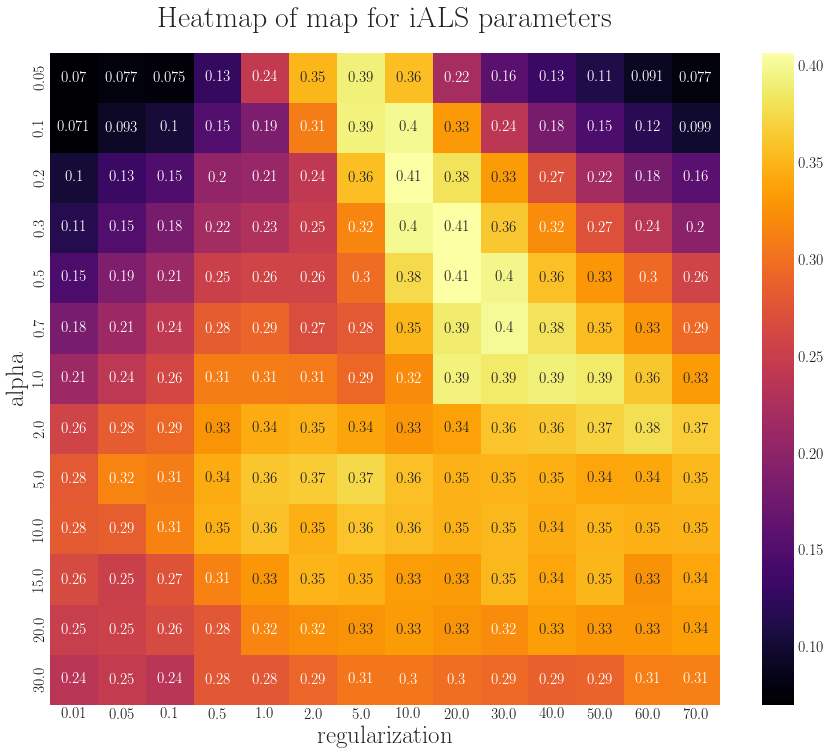

In [174]:
vis.get_heatmap(hyper_test_als, 'iALS', 'map')